<a href="https://colab.research.google.com/github/happysms/Trading/blob/main/protpet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pyupbit

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 100)

In [ ]:
!pip install schedule

In [ ]:
import schedule
import pyupbit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split


mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus = False)

In [ ]:

#BTC 최근 200시간의 데이터 불러옴
df = pyupbit.get_ohlcv("KRW-BTC", interval="minute60")
df

,open,high,low,close,volume,value
2021-07-01 17:00:00,39056000.0,39254000.0,38932000.0,39172000.0,599.576490,2.343209e+10
2021-07-01 18:00:00,39172000.0,39300000.0,38850000.0,38884000.0,438.791119,1.713183e+10
2021-07-01 19:00:00,38884000.0,39109000.0,38668000.0,38941000.0,554.494783,2.155342e+10
2021-07-01 20:00:00,38941000.0,39440000.0,38911000.0,39440000.0,431.164152,1.691942e+10
2021-07-01 21:00:00,39440000.0,39579000.0,39218000.0,39381000.0,399.456578,1.572972e+10
...,...,...,...,...,...,...
2021-07-09 20:00:00,38902000.0,38932000.0,38720000.0,38806000.0,157.531485,6.112965e+09
2021-07-09 21:00:00,38806000.0,38987000.0,38680000.0,38952000.0,193.301025,7.505767e+09
2021-07-09 22:00:00,38952000.0,39500000.0,38923000.0,39354000.0,555.035799,2.178845e+10
2021-07-09 23:00:00,39356000.0,39612000.0,39260000.0,39509000.0,386.680077,1.526101e+10


In [ ]:
#prophet 불러옴
from fbprophet import Prophet

In [ ]:
#학습
model = Prophet()
model.fit(data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [ ]:
#24시간 미래 예측
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

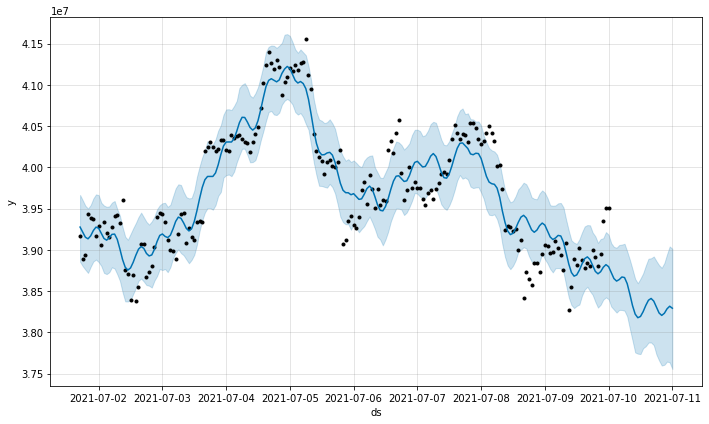

In [ ]:
#그래프1
fig1 = model.plot(forecast)

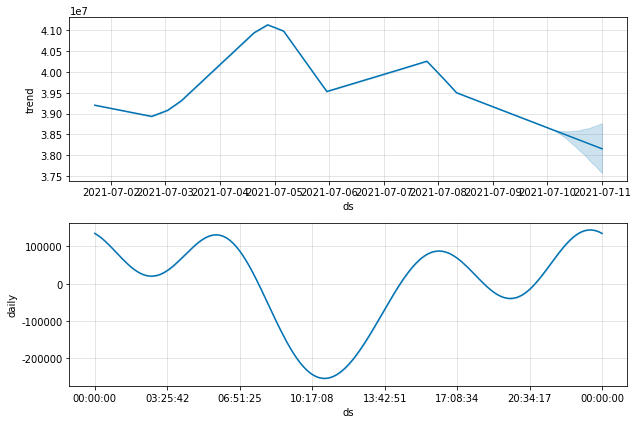

In [ ]:
#그래프2
fig2 = model.plot_components(forecast) 

In [ ]:
closeDf = forecast[forecast['ds'] == data.iloc[-1]['ds'].replace(hour=9)]

In [ ]:
closeDf

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
208,2021-07-10 09:00:00,3.847218e+07,3.790109e+07,3.876613e+07,3.836850e+07,3.857861e+07,-147492.44278,-147492.44278,-147492.44278,-147492.44278,-147492.44278,-147492.44278,0.0,0.0,0.0,3.832468e+07


In [ ]:
def Volatility_predict(df, k, ticker):
    predicted_close_price = 0
    
    temp = pd.DataFrame()
    data = []
    for day in df.index:
        predicted_price = predict_price(day, ticker)
        data.append(predicted_price)
    
    df['predicted_price'] = data
    # df['predicted_price'].fillna("backfill")

    df['range'] = (df['high'] - df['low']) * k
    df['target'] = df['open'] + df['range'].shift(1)
    df['ror'] = np.where((df['high'] > df['target']) & (df['open'] < df['predicted_price']),
                (df['close']*(1 + 0.005)) / (df['target']*(1 + 0.005)),
                1)
    return df

def predict_price(day, ticker):
    """Prophet으로 당일 종가 가격 예측"""
    global predicted_close_price
    df = pyupbit.get_ohlcv(ticker, interval="minute60", to = day)
    df = df.reset_index()
    df['ds'] = df['index']
    df['y'] = df['close']
    data = df[['ds','y']]
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=24, freq='H')
    forecast = model.predict(future)
    closeDf = forecast[forecast['ds'] == forecast.iloc[-1]['ds'].replace(hour=9)]
    if len(closeDf) == 0:
        closeDf = forecast[forecast['ds'] == data.iloc[-1]['ds'].replace(hour=9)]
    closeValue = closeDf['yhat'].values[0]
    return closeValue

# 데이터를 불러온다.
def getdata(ticker="KRW-BTC", count = 200, to=None):
    dfs = [ ]
    date = to
    for i in range(count // 200 + 1):
        if i < count // 200 :
            df = pyupbit.get_ohlcv(ticker, to = date)
            date = df.index[0]
        elif count % 200 != 0 :
            df = pyupbit.get_ohlcv(ticker, to = date, count = count % 200)
        else:
            break
        dfs.append(df)
        time.sleep(0.05)

    df = pd.concat(dfs).sort_index()

    return df




def strategy(df, ticker):
    predicted_close_price = 0
    data = []
    for day in df.index:
        predicted_price = predict_price(day, ticker)
        data.append(predicted_price)
    
    df['predicted_price'] = data

    df['ror'] = np.where(df['open'] < df['predicted_price'] ,
                (df['close']*(1 + 0.005)) / (df['open']*(1 + 0.005)),
                1)

  
    return df


def backtester3(ticker="KRW-BTC", count = 200, to=None, strategy = None, ):
    df = getdata(ticker, count, to)

    df = Volatility_predict(df, ticker)

    df['hpr'] = df['ror'].cumprod()
    df['dd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100
    df['basic_ror'] = ((df['close'] / df['close'].shift(1))).cumprod()    
    (df['basic_ror'])[0] = 1
 
    return df

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with we

 알고리즘 적용 수익률 : 1.2981387135039542 알고리즘 미적용 수익률 : 2.6707872721840435


NameError: ignored

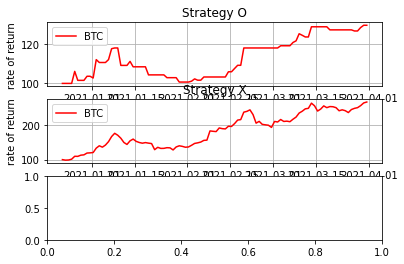

In [ ]:
df_mdd = []

df = backtester3("KRW-BTC" ,count = 100 , to = "2021-04-01")
print(" 알고리즘 적용 수익률 : " + str((df['hpr'])[-1]) + " 알고리즘 미적용 수익률 : " + str((df['basic_ror'])[-1])) 
plt.subplot(311)
plt.plot(df.index, df['hpr']*100, color = 'r', label = 'BTC')
plt.legend(loc='best')
plt.title("Strategy O")
plt.ylabel("rate of return")
plt.grid(True)

plt.subplot(312)
plt.plot(df.index, df['basic_ror'] * 100, color = 'r', label = 'BTC')
plt.legend(loc='best')
plt.title("Strategy X")
plt.ylabel("rate of return")
plt.grid(True)

df_mdd.append(df["dd"].max())
plt.subplot(313)
# plt.bar(x , df_mdd , align='edge', edgecolor="gray", linewidth= 2, width=0.3) 


In [ ]:
df

,open,high,low,close,volume,value,predicted_price,range,target,ror,hpr,dd,basic_ror
2020-12-22 09:00:00,25387000.0,26828000.0,24925000.0,26776000.0,7994.073583,2.061332e+11,2.486559e+07,951500.0,NaN,1.000000,1.000000,0.000000,1.000000
2020-12-23 09:00:00,26776000.0,27070000.0,25600000.0,26380000.0,12398.447606,3.283046e+11,2.704326e+07,735000.0,27727500.0,1.000000,1.000000,0.000000,0.985211
2020-12-24 09:00:00,26380000.0,26608000.0,25774000.0,26503000.0,6661.237365,1.745703e+11,2.663106e+07,417000.0,27115000.0,1.000000,1.000000,0.000000,0.989804
2020-12-25 09:00:00,26503000.0,27271000.0,26171000.0,27122000.0,7979.827412,2.135000e+11,2.620947e+07,550000.0,26920000.0,1.000000,1.000000,0.000000,1.012922
2020-12-26 09:00:00,27122000.0,29524000.0,26983000.0,29378000.0,9647.774225,2.711457e+11,2.781013e+07,1270500.0,27672000.0,1.061651,1.061651,0.000000,1.097177
2020-12-27 09:00:00,29378000.0,31800000.0,28802000.0,29319000.0,19899.625914,6.015242e+11,3.148379e+07,1499000.0,30648500.0,0.956621,1.015597,4.337896,1.094973
2020-12-28 09:00:00,29347000.0,30587000.0,29167000.0,30249000.0,8175.159923,2.455058e+11,3.167245e+07,710000.0,30846000.0,1.000000,1.015597,4.337896,1.129706
2020-12-29 09:00:00,30219000.0,30520000.0,29028000.0,30498000.0,7302.220616,2.180911e+11,2.967333e+07,746000.0,30929000.0,1.000000,1.015597,4.337896,1.139005
2020-12-30 09:00:00,30498000.0,31999000.0,30333000.0,31891000.0,10282.822805,3.209409e+11,3.120719e+07,833000.0,31244000.0,1.020708,1.036628,2.356927,1.191029
2020-12-31 09:00:00,31923000.0,32386000.0,31300000.0,32042000.0,8041.248074,2.567653e+11,3.319579e+07,543000.0,32756000.0,1.000000,1.036628,2.356927,1.196669


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with we

KRW-BTC 알고리즘 적용 수익률 : 1.0581952582267908 알고리즘 미적용 수익률 : 0.9962022346696388


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with we

KRW-ETH 알고리즘 적용 수익률 : 0.919611803435508 알고리즘 미적용 수익률 : 1.0939799331103677


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with we

KRW-XRP 알고리즘 적용 수익률 : 1.2600541186574847 알고리즘 미적용 수익률 : 1.1529051987767585


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with we

kRW-ADA 알고리즘 적용 수익률 : 0.9866886102909144 알고리즘 미적용 수익률 : 1.0460526315789473


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with we

KRW-LTC 알고리즘 적용 수익률 : 0.8511632278223649 알고리즘 미적용 수익률 : 0.9775229357798163


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with we

KRW-DOGE 알고리즘 적용 수익률 : 1.0473684210526315 알고리즘 미적용 수익률 : 1.0257731958762886


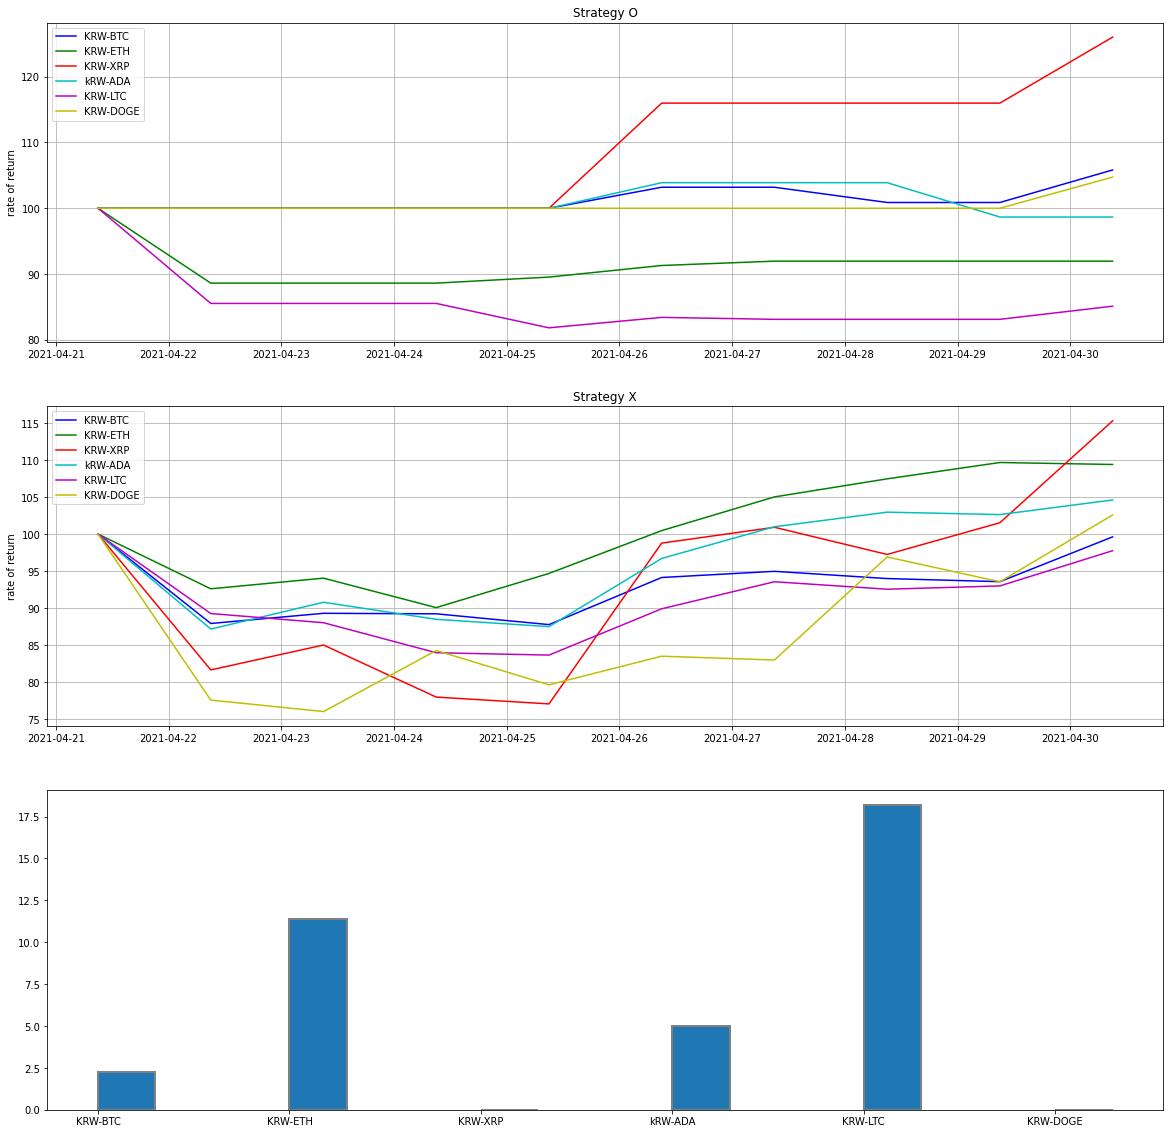

In [ ]:

tickers = [("KRW-BTC", "b"), ("KRW-ETH", "g") , ("KRW-XRP", "r") , ("kRW-ADA", "c") , ("KRW-LTC", "m"), ("KRW-DOGE", "y")]
tics = ["KRW-BTC" , "KRW-ETH" , "KRW-XRP" , "kRW-ADA" , "KRW-LTC" ,"KRW-DOGE"]
df_mdd = []

try:
    plt.figure(figsize = (20, 20))
    for ticker, color in tickers:
        df = backtester3(ticker ,count = 10 , to = "2021-05-01")
        print(ticker + " 알고리즘 적용 수익률 : " + str((df['hpr'])[-1]) + " 알고리즘 미적용 수익률 : " + str((df['basic_ror'])[-1])) 
        
        
        plt.subplot(311)
        plt.plot(df.index, df['hpr']*100, color = color, label = ticker)
        plt.legend(loc='best')
        plt.title("Strategy O")
        plt.ylabel("rate of return")
        plt.grid(True)

        plt.subplot(312)
        plt.plot(df.index, df['basic_ror'] * 100, color = color, label = ticker)
        plt.legend(loc='best')
        plt.title("Strategy X")
        plt.ylabel("rate of return")
        plt.grid(True)

        df_mdd.append(df["dd"].max())


    x = np.arange(len(tickers))
    plt.subplot(313)
    plt.bar(x , df_mdd , align='edge', edgecolor="gray", linewidth= 2, width=0.3, tick_label = tics) 


except Exception as e:
    print(e)

KRW-BTC 알고리즘 적용 수익률 : 1.0581952582267908 알고리즘 미적용 수익률 : 0.9962022346696388
KRW-ETH 알고리즘 적용 수익률 : 0.919611803435508 알고리즘 미적용 수익률 : 1.0939799331103677
KRW-XRP 알고리즘 적용 수익률 : 1.1695529941130245 알고리즘 미적용 수익률 : 1.1529051987767585
kRW-ADA 알고리즘 적용 수익률 : 0.9866886102909144 알고리즘 미적용 수익률 : 1.0460526315789473
KRW-LTC 알고리즘 적용 수익률 : 0.8511632278223649 알고리즘 미적용 수익률 : 0.9775229357798163


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


KRW-DOGE 알고리즘 적용 수익률 : 1.177310990480686 알고리즘 미적용 수익률 : 1.0257731958762886


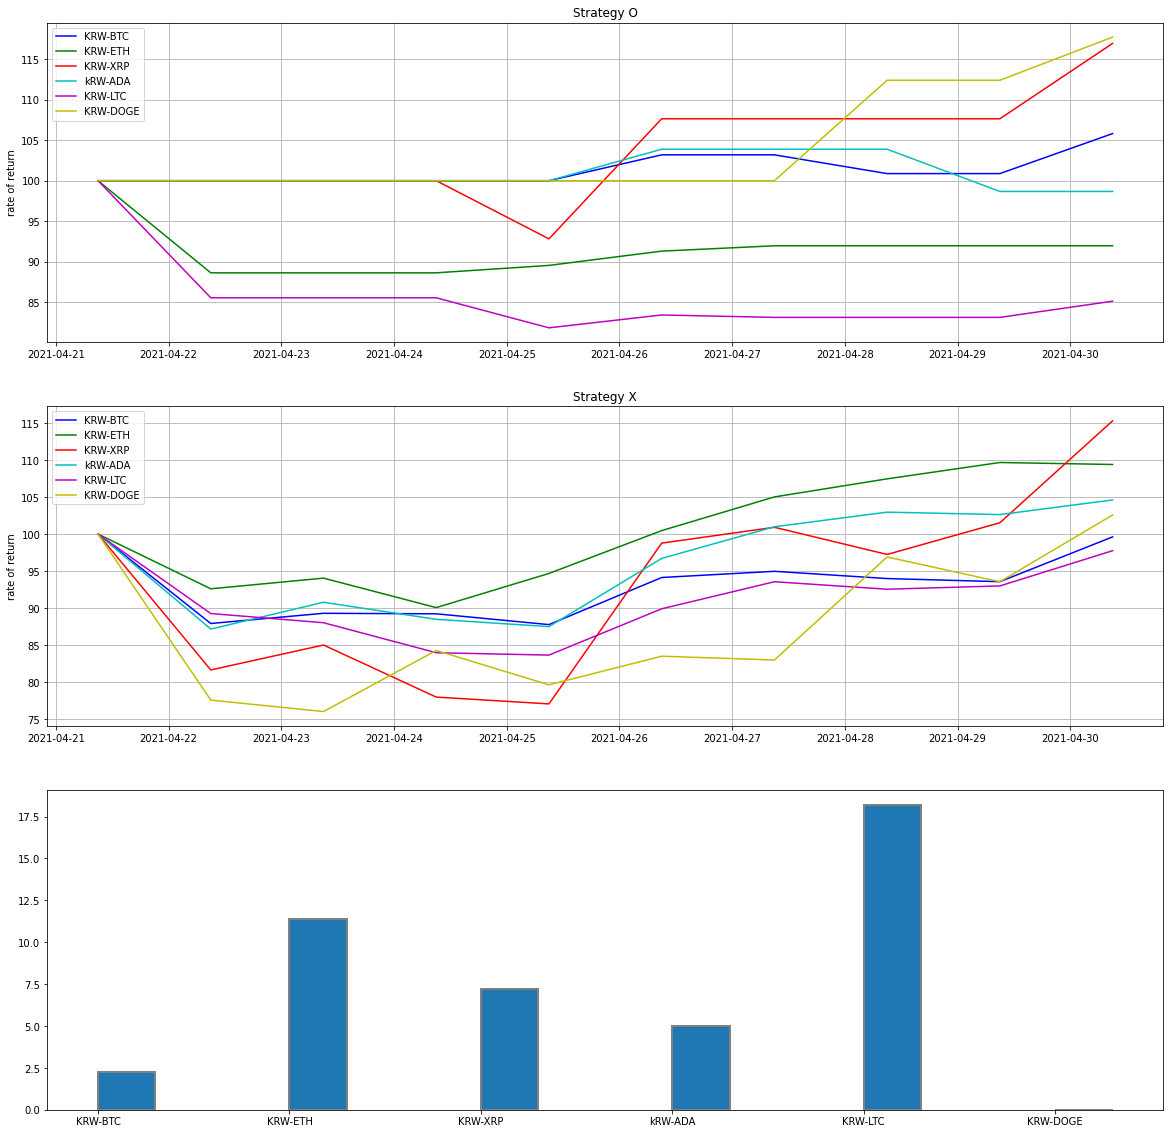

In [ ]:
tickers = [("KRW-BTC", "b"), ("KRW-ETH", "g") , ("KRW-XRP", "r") , ("kRW-ADA", "c") , ("KRW-LTC", "m"), ("KRW-DOGE", "y")]
tics = ["KRW-BTC" , "KRW-ETH" , "KRW-XRP" , "kRW-ADA" , "KRW-LTC" ,"KRW-DOGE"]
df_mdd = []
df_data = []

try:
    plt.figure(figsize = (20, 20))
    for ticker, color in tickers:
        df = backtester1(ticker ,count = 10 , to = "2021-05-01")

        df_data.append(df)
        print(ticker + " 알고리즘 적용 수익률 : " + str((df['hpr'])[-1]) + " 알고리즘 미적용 수익률 : " + str((df['basic_ror'])[-1])) 
        
        
        plt.subplot(311)
        plt.plot(df.index, df['hpr']*100, color = color, label = ticker)
        plt.legend(loc='best')
        plt.title("Strategy O")
        plt.ylabel("rate of return")
        plt.grid(True)

        plt.subplot(312)
        plt.plot(df.index, df['basic_ror'] * 100, color = color, label = ticker)
        plt.legend(loc='best')
        plt.title("Strategy X")
        plt.ylabel("rate of return")
        plt.grid(True)

        df_mdd.append(df["dd"].max())


    x = np.arange(len(tickers))
    plt.subplot(313)
    plt.bar(x , df_mdd , align='edge', edgecolor="gray", linewidth= 2, width=0.3, tick_label = tics) 


except Exception as e:
    print(e)

In [ ]:
df_data

[                           open        high  ...        dd  basic_ror
 2021-04-21 09:00:00  70400000.0  71490000.0  ...  0.000000   1.000000
 2021-04-22 09:00:00  68193000.0  69000000.0  ...  0.000000   0.879234
 2021-04-23 09:00:00  59950000.0  61900000.0  ...  0.000000   0.892988
 2021-04-24 09:00:00  60901000.0  62519000.0  ...  0.000000   0.892299
 2021-04-25 09:00:00  60853000.0  62050000.0  ...  0.000000   0.877724
 2021-04-26 09:00:00  59850000.0  64300000.0  ...  0.000000   0.941347
 2021-04-27 09:00:00  64198000.0  65000000.0  ...  0.000000   0.949691
 2021-04-28 09:00:00  64759000.0  65899000.0  ...  2.244115   0.939910
 2021-04-29 09:00:00  64060000.0  64900000.0  ...  2.244115   0.935717
 2021-04-30 09:00:00  63816000.0  68540000.0  ...  0.000000   0.996202
 
 [10 rows x 12 columns],
                           open       high  ...         dd  basic_ror
 2021-04-21 09:00:00  2908000.0  3069000.0  ...   0.000000   1.000000
 2021-04-22 09:00:00  2990000.0  3174000.0  ...  11.